Deepliver with Inverse weights

With class weighting: 1 15 175

Classifying liver and lesion

database: liver-lesion-400

batch size: 10

In [1]:
# Most Code here
import sys
#Switch to deepliver
if "/opt/caffe/python" in sys.path : sys.path.remove("/opt/caffe/python")
if "/opt/deepliver/python" not in sys.path : sys.path.insert(0,"/opt/deepliver/python")

import plyvel, lutils, math, re
from collections import defaultdict
import numpy as np
from matplotlib import pyplot as plt
plt.set_cmap('gray')
%matplotlib inline

def hist(arr):
    """Print number of pixels for each label in the given image (arr)"""
    return "%.3f , %.3f , %.3f, %.3f" % (np.sum(arr==0),np.sum(arr==1),np.sum(arr==2),np.sum(arr==4))

def imshow(*args,**kwargs):
    """ Handy function to show multiple plots in on row, possibly with different cmaps
    Usage: 
    imshow(img1, title="myPlot")
    imshow(img1,img2)
    imshow(img1,img2, cmap='hot')
    imshow(img1,img2,cmap=['gray','Blues']) """
    cmap = kwargs.get('cmap', 'gray')
    if len(args)==0:
        raise ValueError("No images given to imshow")
    elif len(args)==1:
        title=kwargs.get('title','')
        plt.title(title)
        plt.imshow(args[0], interpolation='none')
    else:
        n=len(args)
        if type(cmap)==str:
            cmap = [cmap]*n
        plt.figure(figsize=(n*5,10))
        for i in range(n):
            plt.subplot(1,n,i+1)
            plt.imshow(args[i], cmap[i])
    plt.show()
        
def dice(prediction, segmentation, label_of_interest = 1):
    """ Takes 2 2-D arrays with class labels, and return a float dice score.
    Only label=label_of_interest is considered """
    if prediction.shape != segmentation.shape:
        raise ValueError("Shape mismatch between given arrays. prediction %s vs segmentation %s" \
                         % (str(prediction.shape), str(segmentation.shape)))

    n_liver_seg = np.sum(segmentation==label_of_interest)
    n_liver_pred= np.sum(prediction == label_of_interest)
    denominator = n_liver_pred + n_liver_seg
    if denominator == 0:
        return -1

    liver_intersection   = np.logical_and(prediction==label_of_interest, segmentation==label_of_interest)
    n_liver_intersection = np.sum(liver_intersection)

    dice_score = 2.0*n_liver_intersection / denominator
    return dice_score

def protobinary_to_array(filename, outpng=None):
    """ Filename is path to protobinary
    outpng is path to output png"""
    with open(filename,'r') as f:
        data = f.read()

    blob = caffe.proto.caffe_pb2.BlobProto()
    blob.ParseFromString(data)
    arr = np.array(caffe.io.blobproto_to_array(blob)) #returns shape (1,1,W,H)
    arr = arr[0,0,:,:] #ignore first 2 dimensions
    return  arr

dices_liver = []
dices_lesion= []
def predict(net, img, seg, meanimg):
    """Predicts an img using the trained net, and compares it to the label image (seg)"""
    net.blobs['data'].data[0]=(img-meanimg)
    prob=net.forward()['prob'][0]
    prediction = np.argmax(prob,axis=0)
    dice_liver = dice(prediction,seg,label_of_interest=1)
    dice_lesion = dice(prediction,seg,label_of_interest=2)
    dices_liver.append(dice_liver)
    dices_lesion.append(dice_lesion)
    print "Dice Liver:", dice_liver
    print "Dice Lesion:",dice_lesion
    print "Prediction class histogram",hist(prediction)
    print "Ground truth class histogram",hist(seg)
    plt.figure(figsize=(20,24))
    plt.subplot(1,3,1); plt.title("Image")
    plt.imshow(img)
    plt.subplot(1,3,2); plt.title("Ground truth")
    plt.imshow(seg)
    plt.subplot(1,3,3); plt.title("Prediction")
    plt.imshow(prediction)
    plt.show()
    
def read_imgs(dbimg, dbseg, n=1):
    """Read img and label after skipping n keys in leveldb"""
    for _ in range(n):
        k1,vimg = dbimgit.next()
        k2,vseg = dbsegit.next()

    print "Keys:",k1,k2
    img=lutils.to_numpy_matrix(vimg)
    seg=lutils.to_numpy_matrix(vseg)
    return img,seg

def show_kernels(layer_blob_data, fast = False):
    """ Takes solver.net.params['conv1'][0].data and visualize the first channel of all kernels.
    If fast = False : subplots will be used, allowing to see each filter individually, but takes time.
    If fast = True : all filters are plotted in one image"""
    #Input has 4 dims, we only visualize 1st channel of each kernel 
    # (the conv weights that acts on the 1st channel of the input)
    data = layer_blob_data[:,0,:,:]
    if fast:
        raise NotImplementedError("todo")
    n_kernels = data.shape[0]
    plot_cols = 10 #number of images in one row
    plot_rows = math.ceil(n_kernels*1.0 / plot_cols)
    # Adjust figure plot size
    plt.figure(figsize=(min(plot_cols, n_kernels)*2, plot_rows*2))
    # Plot !
    for i in range(n_kernels):
        plt.subplot(plot_rows, plot_cols, i+1)
        plt.imshow(data[i], interpolation='none')
        
def plot_deepliver_log(fname):
    """Takes file handle of deepliver log, and plots the 4 plots :
    Loss, avgAccuracy, avgJaccard, avgRecall"""
    f = open(fname, 'r')
    logs = f.read()

    # Get iterations
    iterations = re.findall("Iteration (\d+), loss",logs)

    # Get&plot loss
    loss = zip(*re.findall("Iteration \d+, loss = ([+-]?(\d+(\.\d*)?|\.\d+)([eE][+-]?\d+)?)",logs))[0]
    length = min(len(iterations), len(loss))
    iterations_trunc, loss_trunc = iterations[:length], loss[:length]
    plt.plot(iterations,loss,label='Loss')
    #plt.show()
    #Get&plot metrics
    metrics = ['Accuracy','Recall','Jaccard']
    data = defaultdict(list) # data.keys() = metrics , data[metrics[0]] = list of values
    for i,metric in enumerate(metrics):
        regex = "Train net output #"+str(i)+": accuracy = ([+-]?(\d+(\.\d*)?|\.\d+)([eE][+-]?\d+)?)"
        for result in re.findall(regex,logs):
            data[metric].append(result[0])

    for metric in data.keys():
        length = min(len(iterations),len(data[metric]))
        iterations_trunc, data_trunc = iterations[:length], data[metric][:length]
        plt.plot(iterations_trunc, data_trunc,label=metric)
        plt.legend(loc="lower center",prop={'size':8})
    f.close()

In [2]:
import caffe
print caffe.__file__
caffe.set_mode_gpu()

/opt/deepliver/python/caffe/__init__.pyc


# Learning plots #

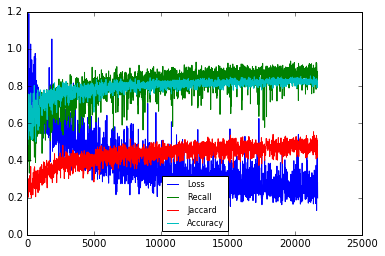

In [3]:
plot_deepliver_log("caffe.INFO")

# Example predictions #

In [4]:
net=caffe.Net("deploy_deepliverweights.prototxt","snapshot/_iter_20000.caffemodel",caffe.TEST)
mean = protobinary_to_array("mean.protobinary")

In [5]:
try:dbimg.close()
except: pass
dbimg=plyvel.DB("test_img/")
dbimgit=dbimg.iterator()
try: dbseg.close()
except: pass
dbseg=plyvel.DB("test_seg/")
dbsegit=dbseg.iterator()

Keys: 00027_00211953_00086_img_xy_0353_15 00027_00211953_00086_seg_xy_0353_15
Dice Liver: 0.706570312301
Dice Lesion: 0.0
Prediction class histogram 133115.000 , 23712.000 , 3173.000, 0.000
Ground truth class histogram 144551.000 , 15449.000 , 0.000, 0.000


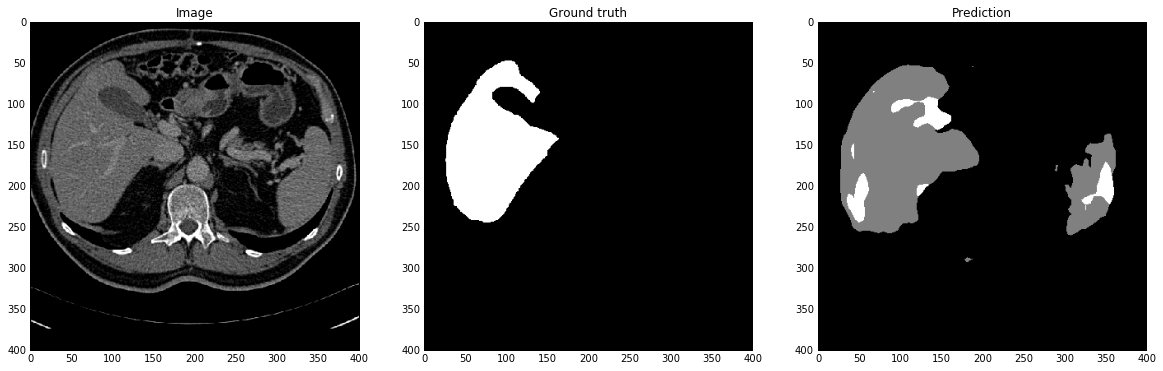

In [6]:
img,seg = read_imgs(dbimg,dbseg,20)
pred = predict(net,img,seg,mean)

Keys: 00454_00222081_00089_img_xy_0398_11 00454_00222081_00089_seg_xy_0398_11
Dice Liver: 0.834493530535
Dice Lesion: 0.0
Prediction class histogram 129895.000 , 29483.000 , 622.000, 0.000
Ground truth class histogram 137489.000 , 22376.000 , 135.000, 0.000


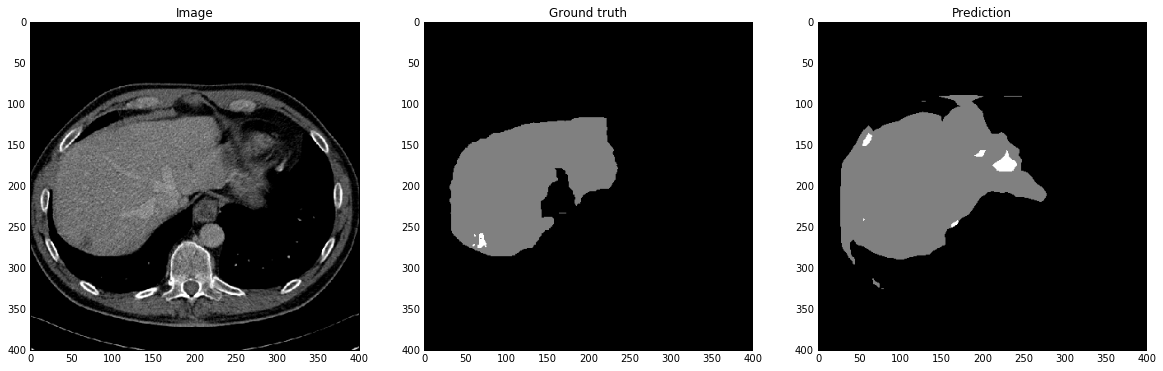

In [7]:
img,seg = read_imgs(dbimg,dbseg,200)
pred = predict(net,img,seg,mean)

Keys: 00875_00203539_00083_img_xy_0306_16 00875_00203539_00083_seg_xy_0306_16
Dice Liver: 0.460962258715
Dice Lesion: 0.0
Prediction class histogram 157224.000 , 2582.000 , 194.000, 0.000
Ground truth class histogram 159111.000 , 889.000 , 0.000, 0.000


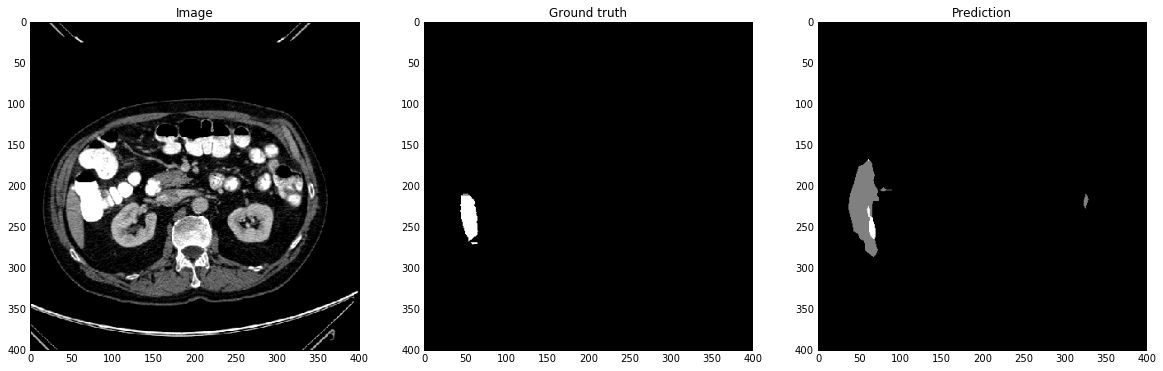

In [8]:
img,seg = read_imgs(dbimg,dbseg,200)
pred = predict(net,img,seg,mean)

Keys: 01290_00218543_00088_img_xy_0432_09 01290_00218543_00088_seg_xy_0432_09
Dice Liver: 0.873101257003
Dice Lesion: 0.0
Prediction class histogram 139873.000 , 19647.000 , 480.000, 0.000
Ground truth class histogram 143768.000 , 16232.000 , 0.000, 0.000


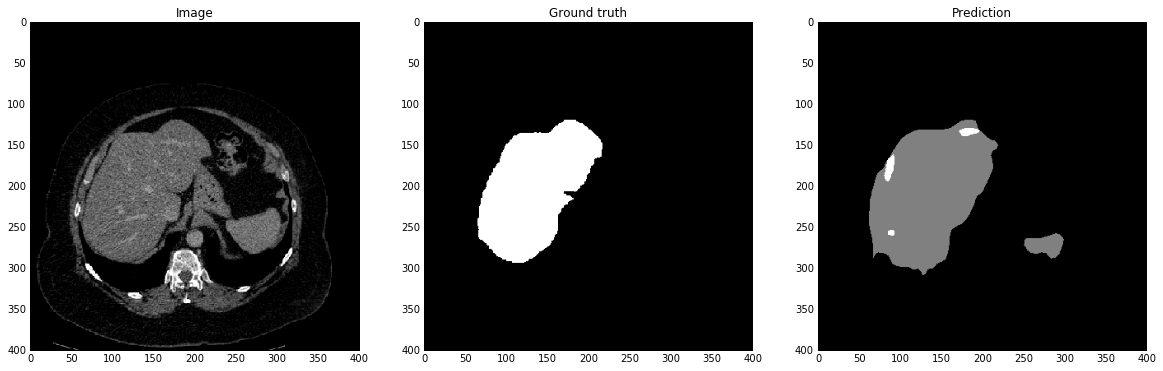

In [9]:
img,seg = read_imgs(dbimg,dbseg,200)
pred = predict(net,img,seg,mean)

Keys: 01675_00238529_00094_img_xy_0829_03 01675_00238529_00094_seg_xy_0829_03
Dice Liver: 0.417774187033
Dice Lesion: 0.262970168612
Prediction class histogram 137959.000 , 18583.000 , 3458.000, 0.000
Ground truth class histogram 151118.000 , 6172.000 , 2710.000, 0.000


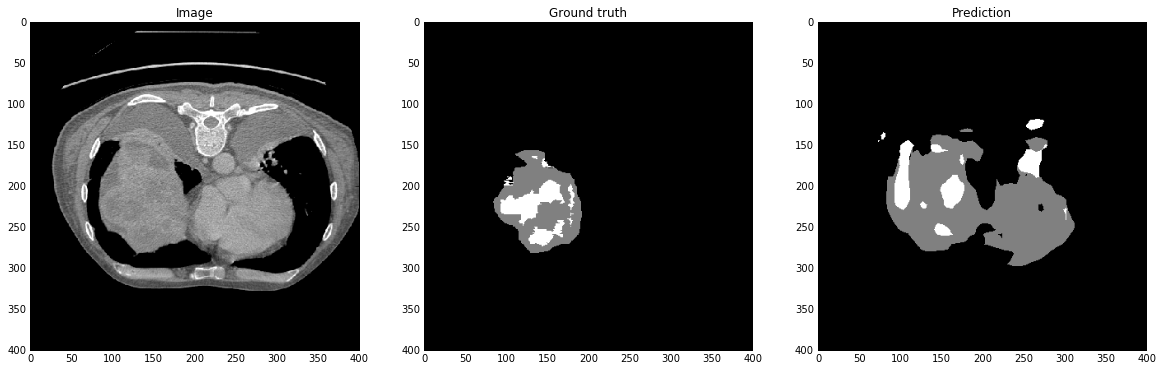

In [10]:
img,seg = read_imgs(dbimg,dbseg,200)
pred = predict(net,img,seg,mean)

Keys: 02057_00252622_00100_img_xy_0120_03 02057_00252622_00100_seg_xy_0120_03
Dice Liver: 0.156252384222
Dice Lesion: 0.0
Prediction class histogram 145766.000 , 9273.000 , 4961.000, 0.000
Ground truth class histogram 156166.000 , 3834.000 , 0.000, 0.000


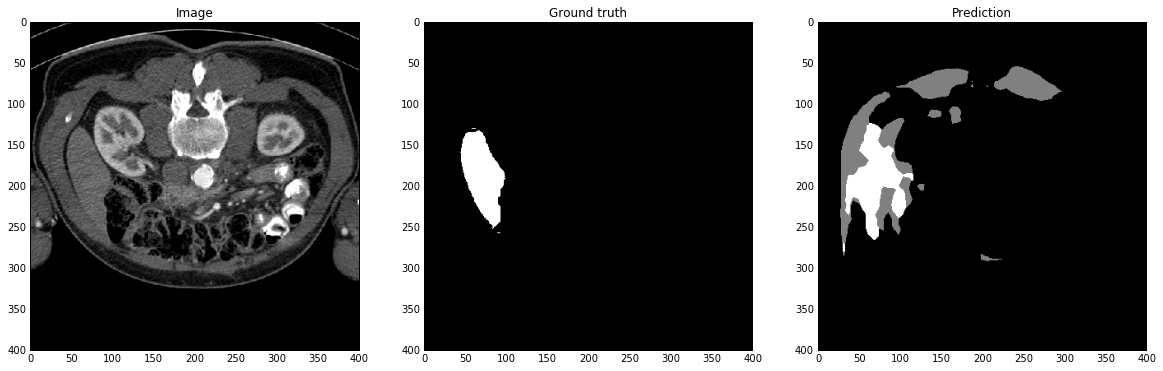

In [11]:
img,seg = read_imgs(dbimg,dbseg,200)
pred = predict(net,img,seg,mean)

Keys: 02466_00238288_00094_img_xy_0814_17 02466_00238288_00094_seg_xy_0814_17
Dice Liver: 0.281358281358
Dice Lesion: 0.357481192533
Prediction class histogram 133200.000 , 19271.000 , 7529.000, 0.000
Ground truth class histogram 146470.000 , 6703.000 , 6827.000, 0.000


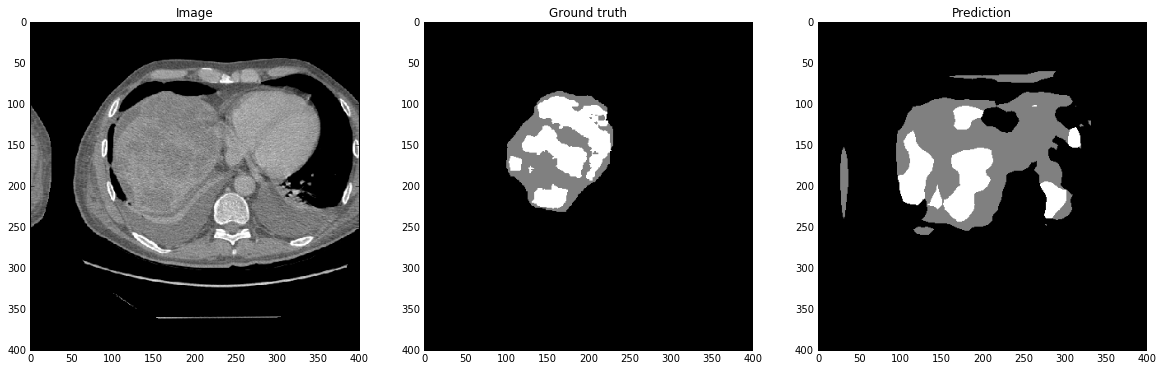

In [12]:
img,seg = read_imgs(dbimg,dbseg,200)
pred = predict(net,img,seg,mean)

Keys: 02861_00205674_00084_img_xy_0262_09 02861_00205674_00084_seg_xy_0262_09
Dice Liver: 0.0
Dice Lesion: 0.0
Prediction class histogram 151822.000 , 7274.000 , 904.000, 0.000
Ground truth class histogram 159936.000 , 64.000 , 0.000, 0.000


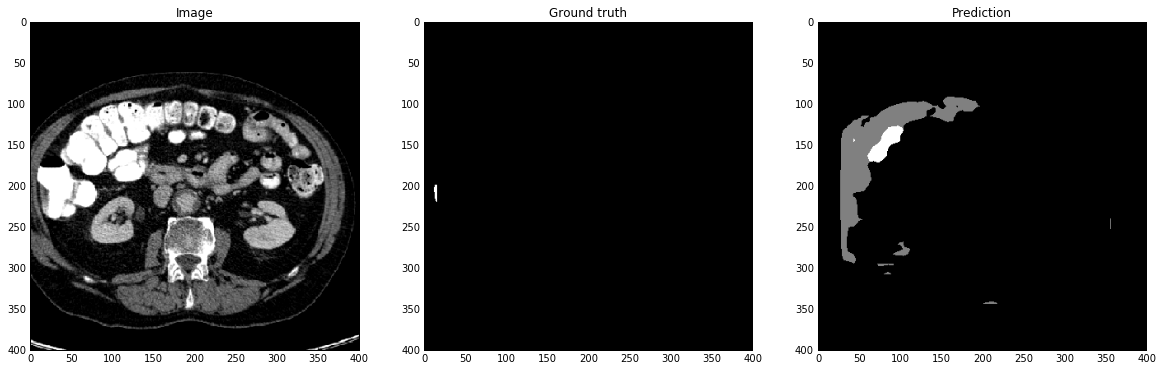

In [13]:
img,seg = read_imgs(dbimg,dbseg,200)
pred = predict(net,img,seg,mean)

Keys: 03208_00242298_00096_img_xy_0409_15 03208_00242298_00096_seg_xy_0409_15
Dice Liver: 0.735745698634
Dice Lesion: 0.663340724316
Prediction class histogram 149445.000 , 7173.000 , 3382.000, 0.000
Ground truth class histogram 152182.000 , 5788.000 , 2030.000, 0.000


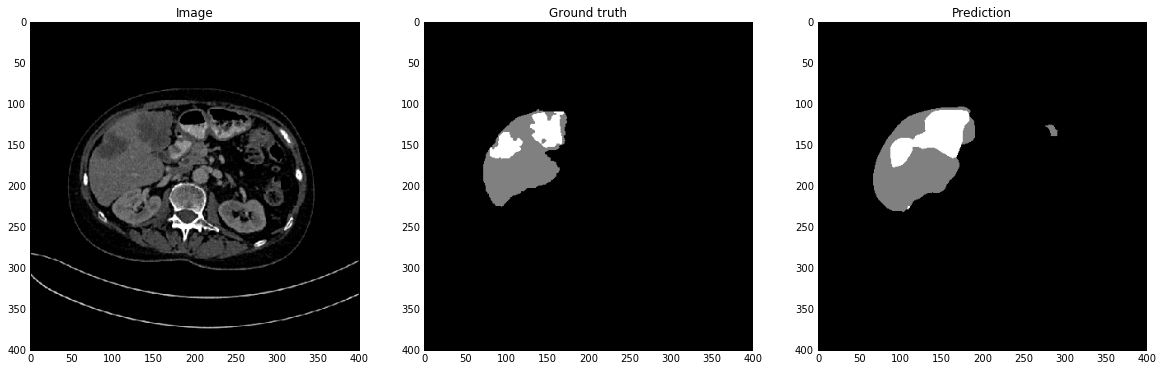

In [14]:
img,seg = read_imgs(dbimg,dbseg,200)
pred = predict(net,img,seg,mean)

Keys: 03553_00245788_00097_img_xy_0459_03 03553_00245788_00097_seg_xy_0459_03
Dice Liver: 0.746743054466
Dice Lesion: 0.0
Prediction class histogram 144031.000 , 15831.000 , 138.000, 0.000
Ground truth class histogram 150347.000 , 9653.000 , 0.000, 0.000


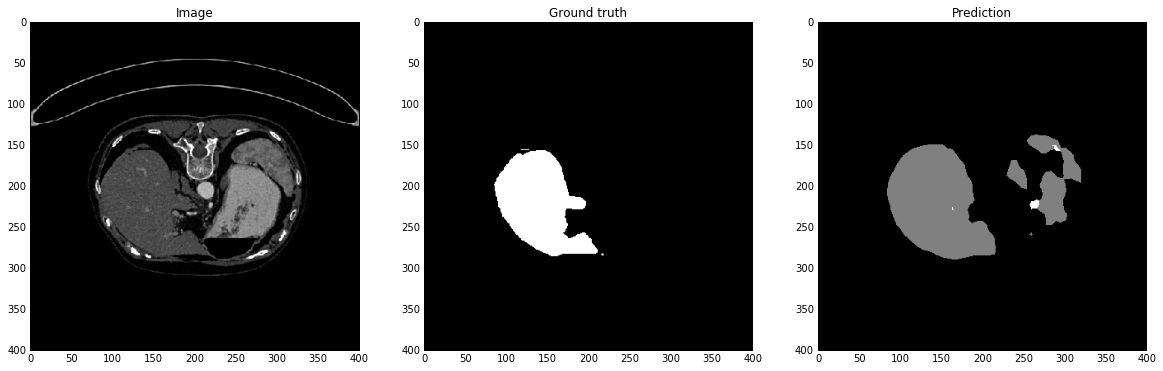

In [15]:
img,seg = read_imgs(dbimg,dbseg,200)
pred = predict(net,img,seg,mean)

Keys: 03653_00223267_00090_img_xy_0373_07 03653_00223267_00090_seg_xy_0373_07
Dice Liver: 0.729843270318
Dice Lesion: 0.0
Prediction class histogram 142932.000 , 15069.000 , 1999.000, 0.000
Ground truth class histogram 150313.000 , 9687.000 , 0.000, 0.000


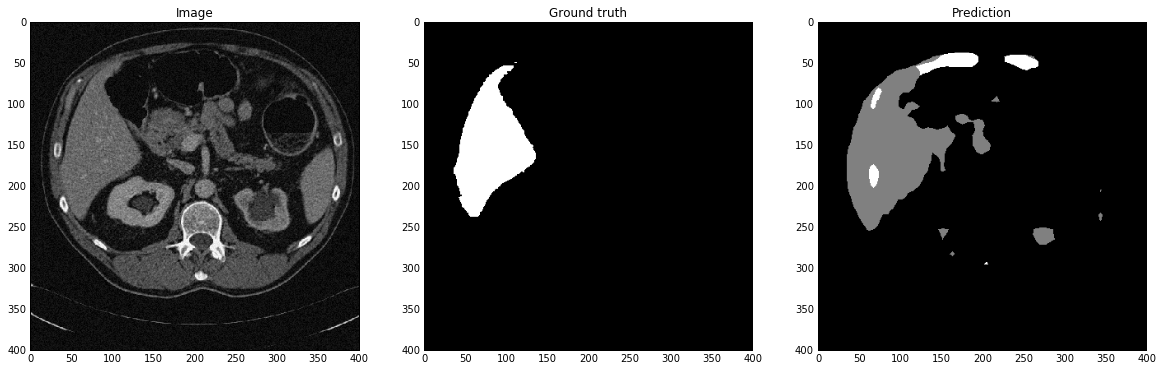

In [16]:
img,seg = read_imgs(dbimg,dbseg,50)
pred = predict(net,img,seg,mean)

Keys: 04010_00220328_00089_img_xy_0308_09 04010_00220328_00089_seg_xy_0308_09
Dice Liver: 0.45767996332
Dice Lesion: 0.0
Prediction class histogram 145897.000 , 12726.000 , 1377.000, 0.000
Ground truth class histogram 150916.000 , 9084.000 , 0.000, 0.000


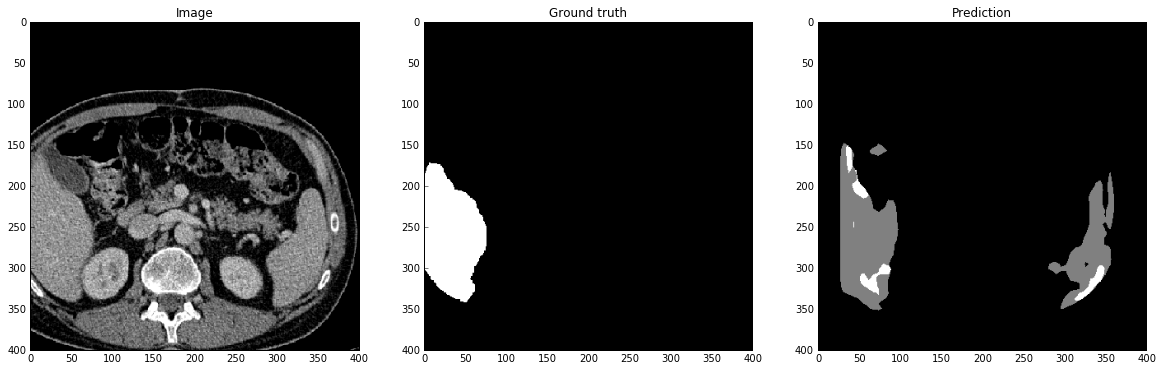

In [17]:
img,seg = read_imgs(dbimg,dbseg,200)
pred = predict(net,img,seg,mean)

Keys: 04390_00242662_00096_img_xy_0431_05 04390_00242662_00096_seg_xy_0431_05
Dice Liver: 0.678622029713
Dice Lesion: 0.198179979778
Prediction class histogram 143524.000 , 15466.000 , 1010.000, 0.000
Ground truth class histogram 148806.000 , 9237.000 , 1957.000, 0.000


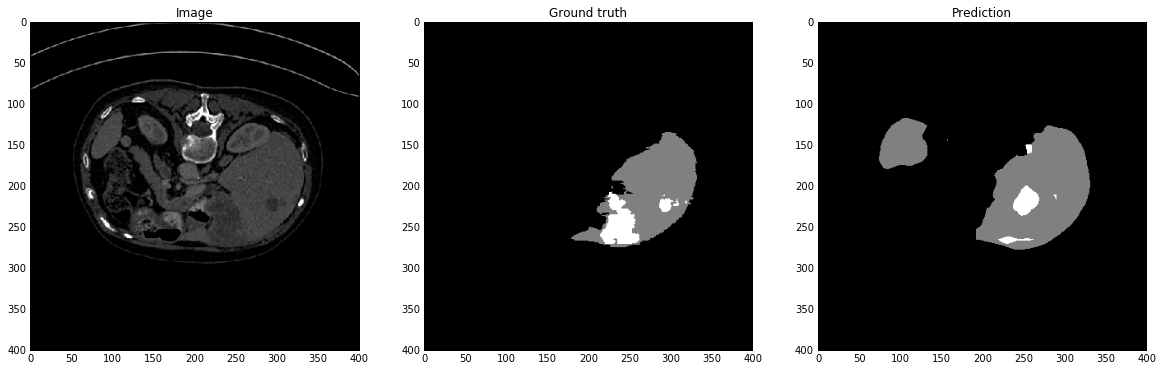

In [18]:
img,seg = read_imgs(dbimg,dbseg,200)
pred = predict(net,img,seg,mean)

Keys: 04572_00236283_00094_img_xy_0697_00 04572_00236283_00094_seg_xy_0697_00
Dice Liver: 0.742199461486
Dice Lesion: 0.48208036684
Prediction class histogram 121373.000 , 30992.000 , 7635.000, 0.000
Ground truth class histogram 125230.000 , 25831.000 , 8939.000, 0.000


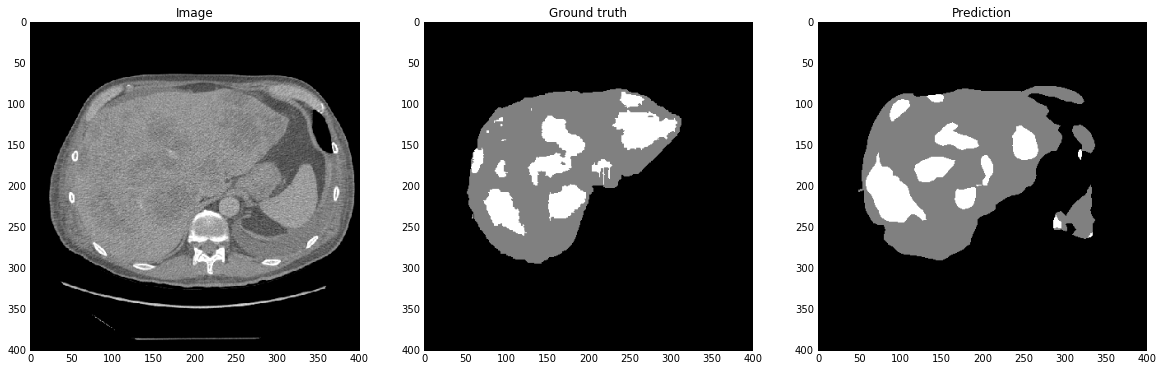

In [19]:
img,seg = read_imgs(dbimg,dbseg,100)
pred = predict(net,img,seg,mean)

Keys: 04724_00224466_00090_img_xy_0443_16 04724_00224466_00090_seg_xy_0443_16
Dice Liver: 0.824567855829
Dice Lesion: 0.0
Prediction class histogram 126398.000 , 31287.000 , 2315.000, 0.000
Ground truth class histogram 136907.000 , 23093.000 , 0.000, 0.000


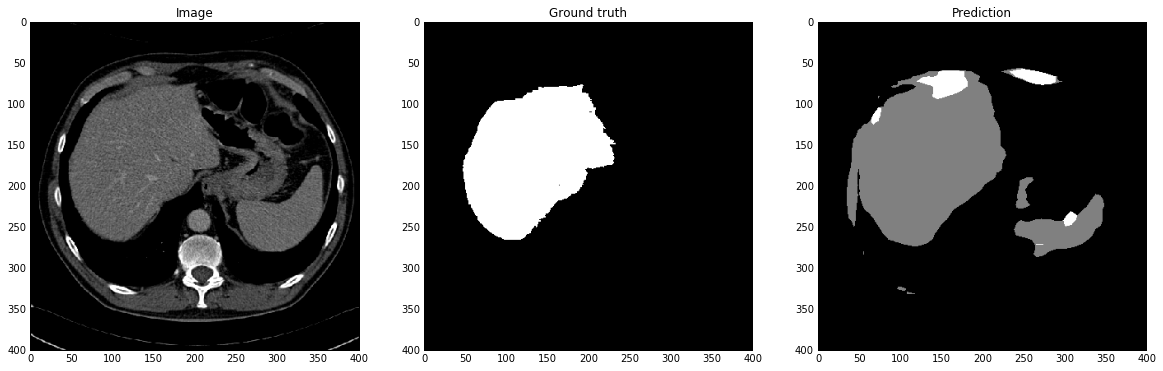

In [20]:
img,seg = read_imgs(dbimg,dbseg,100)
pred = predict(net,img,seg,mean)

Keys: 05124_00238367_00094_img_xy_0819_11 05124_00238367_00094_seg_xy_0819_11
Dice Liver: 0.368307303348
Dice Lesion: 0.262375817271
Prediction class histogram 135838.000 , 17861.000 , 6301.000, 0.000
Ground truth class histogram 147862.000 , 6662.000 , 5476.000, 0.000


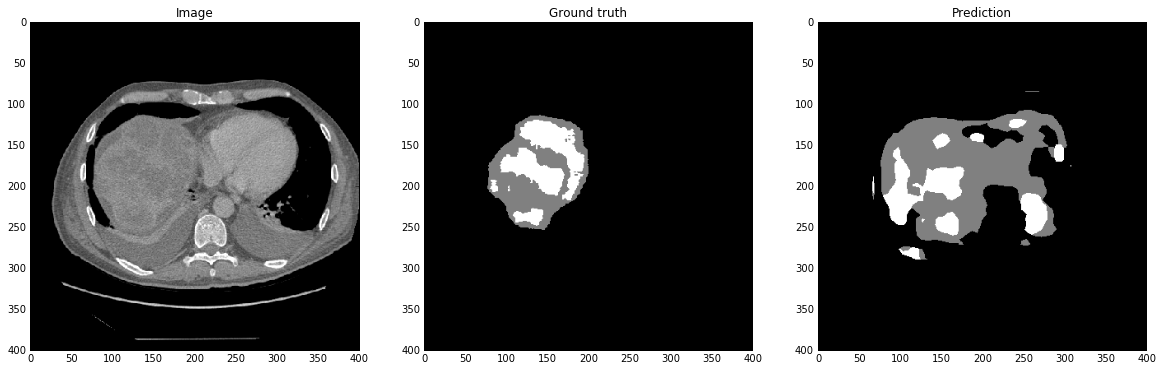

In [21]:
img,seg = read_imgs(dbimg,dbseg,240)
pred = predict(net,img,seg,mean)

Keys: 05134_00213221_00086_img_xy_0437_08 05134_00213221_00086_seg_xy_0437_08
Dice Liver: 0.521936768987
Dice Lesion: 0.0
Prediction class histogram 127787.000 , 27910.000 , 4303.000, 0.000
Ground truth class histogram 148752.000 , 11248.000 , 0.000, 0.000


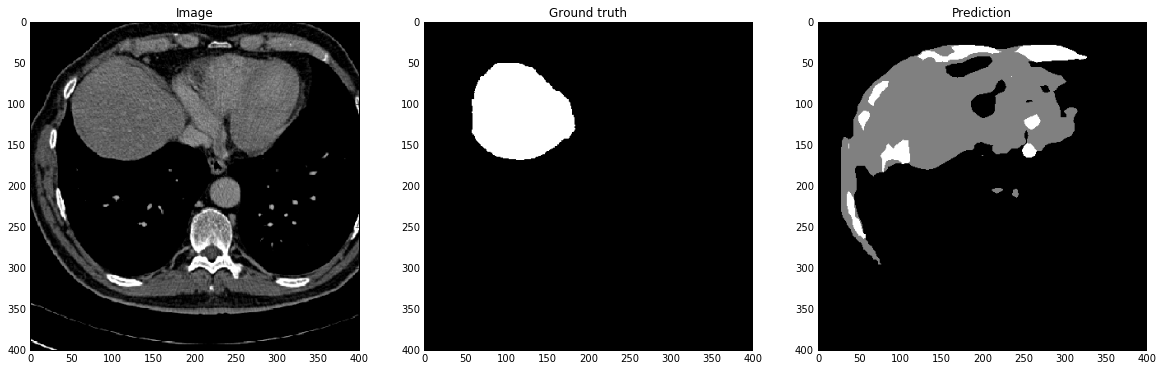

In [22]:
img,seg = read_imgs(dbimg,dbseg,5)
pred = predict(net,img,seg,mean)

Keys: 05136_00239574_00095_img_xy_0096_11 05136_00239574_00095_seg_xy_0096_11
Dice Liver: 0.630437441396
Dice Lesion: 0.0
Prediction class histogram 142911.000 , 16008.000 , 1081.000, 0.000
Ground truth class histogram 151479.000 , 8521.000 , 0.000, 0.000


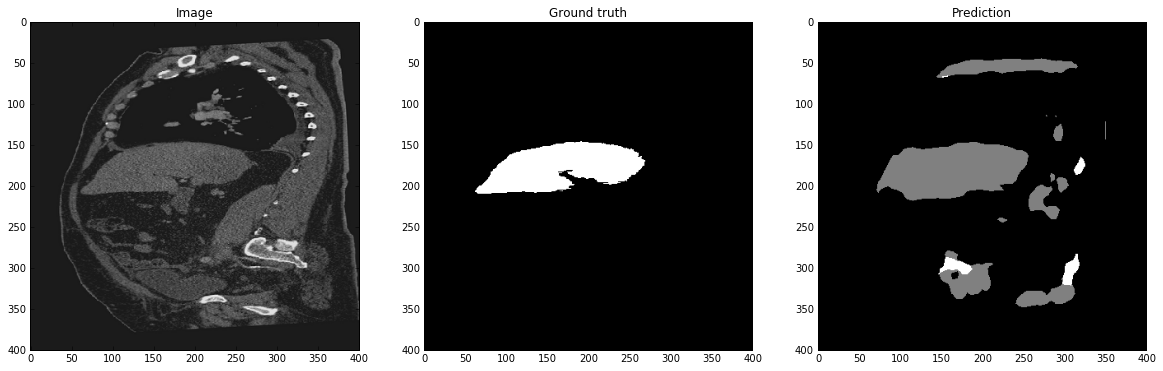

In [23]:
img,seg = read_imgs(dbimg,dbseg,1)
pred = predict(net,img,seg,mean)

Keys: 05136_00252924_00100_img_xy_0185_16 05136_00252924_00100_seg_xy_0185_16
Dice Liver: 0.38206432204
Dice Lesion: 0.0
Prediction class histogram 147014.000 , 11208.000 , 1778.000, 0.000
Ground truth class histogram 157247.000 , 2753.000 , 0.000, 0.000


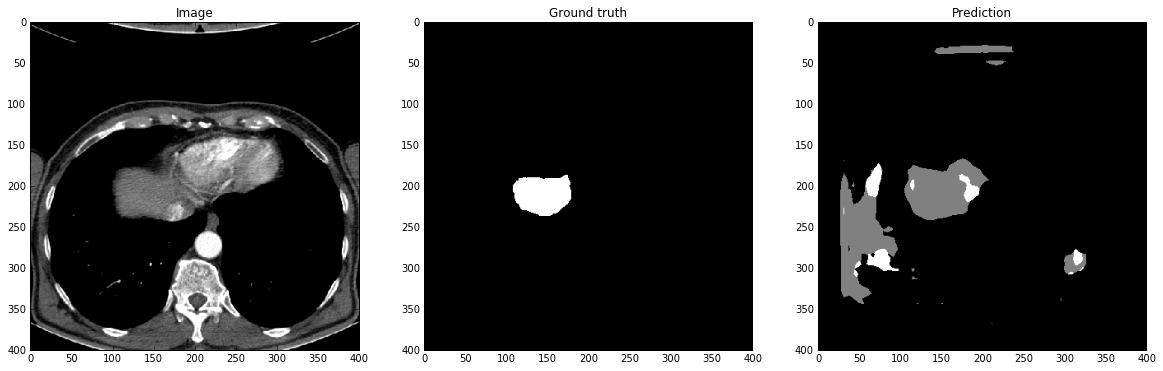

In [24]:
img,seg = read_imgs(dbimg,dbseg,1)
pred = predict(net,img,seg,mean)

In [25]:
print "Average of above Liver dices :",np.mean(dices_liver)
print "Average of above Lesion dices :",np.mean(dices_lesion)

Average of above Liver dices : 0.555192598984
Average of above Lesion dices : 0.117180434176


In [26]:
# Network used :
!cat train_deepliverweights.prototxt

name: "DeepLiver"

# Import Layer
layer {
  name: "data"
  type: "Data"
  top: "data"
  include {
    phase: TRAIN
  }
  transform_param {
    mean_file: "mean.protobinary"
  }
  data_param {
    source: "train_img"
    batch_size: 10
    backend: LEVELDB
  }
}
layer {
  name: "label"
  type: "Data"
  top: "label"
  include {
    phase: TRAIN
  }
  data_param {
    source: "train_seg"
    batch_size: 10
    backend: LEVELDB
  }
}
layer {
  name: "data"
  type: "Data"
  top: "data"
  include {
    phase: TEST
  }
  transform_param {
    mean_file: "mean.protobinary"
  }
  data_param {
    source: "test_img"
    batch_size: 10
    backend: LEVELDB
  }
}
layer {
  name: "label"
  type: "Data"
  top: "label"
  include {
    phase: TEST
  }
  data_param {
    source: "test_seg"
    batch_size: 10
    backend: LEVELDB
  }
}

#### NETWORK ### Conv Layer

layer {
  bottom: "data"
  top: "conv1"
  name: "conv1"
  type: "Convolution"
  param { lr_mult: 1 }
  param { lr_mult: 2 }
  convolution_pa

In [27]:
# Solver used :
!cat solver_deepliverweights.prototxt

# Dataset: stat-10-15-15-aug6-400-float
# 261960

net: "train_deepliverweights.prototxt"

#test_iter: 100
#test_interval: 1000

lr_policy: "step"
gamma: 0.1 # 0.0001
stepsize: 50000 # f��r batch size 40 -> 8 Epochen
base_lr: 0.01

display: 10
max_iter: 100000000 # f��r batch size 48 -> 24 Epochen
momentum: 0.8
weight_decay: 0.0005

snapshot: 1000
snapshot_prefix: "snapshot/"
solver_mode: GPU

